In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name, available_dates
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


contracts data available for SPY:
0       2024-10-11
1       2024-10-10
2       2024-10-09
3       2024-10-08
4       2024-10-07
           ...    
2019    2016-09-28
2020    2016-09-27
2021    2016-09-26
2022           NaN
2023           NaN
Name: 0, Length: 2024, dtype: object

                   raw_data_key               surface_key  \
0     /date_2024_10_11/raw_data  /date_2024_10_11/surface   
1     /date_2024_10_10/raw_data  /date_2024_10_10/surface   
2     /date_2024_10_09/raw_data  /date_2024_10_09/surface   
3     /date_2024_10_08/raw_data  /date_2024_10_08/surface   
4     /date_2024_10_07/raw_data  /date_2024_10_07/surface   
...                         ...                       ...   
2019  /date_2016_09_28/raw_data                       NaN   
2020  /date_2016_09_27/raw_data                       NaN   
2021  /date_2016_09_26/raw_data                       NaN   
2022                        NaN                       NaN   
2023                        NaN                

# available time-series

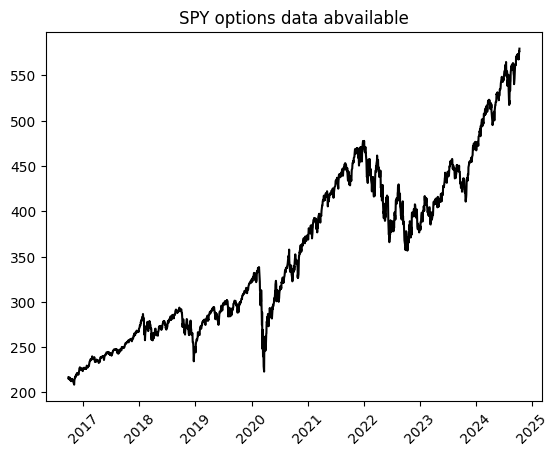

<Figure size 640x480 with 0 Axes>

In [2]:
spot_keys = keys_df.loc[:,['spot_price','date']].dropna()
spots = pd.Series(np.zeros(len(spot_keys)),index=spot_keys['date'])
spots.index = [datetime.strptime(date, '%Y-%m-%d') for date in spots.index.tolist()]
store.open()
for i,row in spot_keys.iterrows():
    spot_price = float(store[row['spot_price']].iloc[0])
    date = row['date']
    spots[date] = spot_price
store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data abvailable')
plt.show()
plt.clf()

# volatility surface query

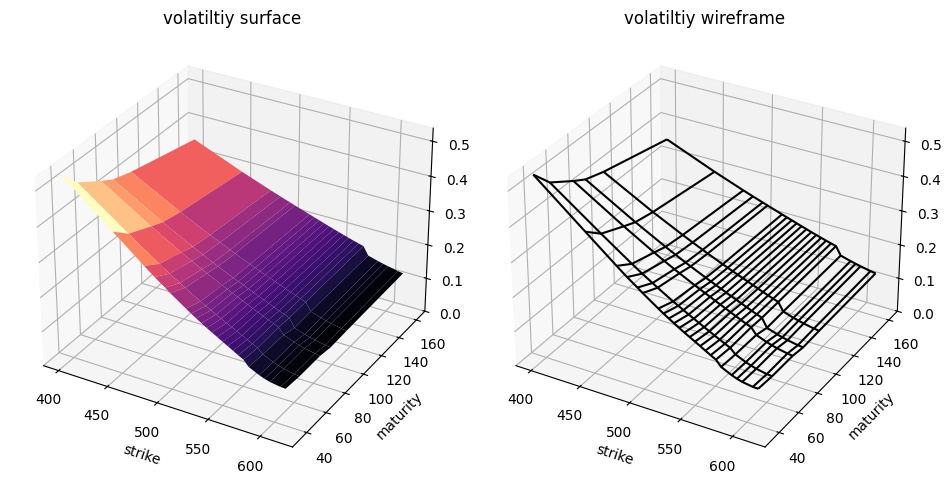

<Figure size 640x480 with 0 Axes>

In [3]:
from historical_av_plot_vol_surface import plot_vol_surface
surface_keys = keys_df.dropna(subset='surface_key').iloc[:1]
while True:
    try:
        store.open()
        surface = store[surface_keys.iloc[0]['surface_key']]
        break
    except OSError:
        time.sleep(2)
    finally:
        store.close()

plot_vol_surface(surface)

# calibrations

In [6]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
            parameters[row['date']] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
# calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
# calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

calibrations
# for col in parameters.columns:
#     plt.figure()
#     plt.plot(calibrations[col], color='black')
#     plt.xticks(rotation=45)
#     plt.title(symbol + ' ' + col)
#     plt.show()
#     plt.clf()
# print(f"\n{calibrations.reset_index().describe()}")

,strike_price,w,market_price,volatility,days_to_maturity,calculation_date,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,error
0,260.000000,call,320.910000,0.245830,35,1970-01-21 00:10:04.800,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.229154,320.575350,320.594510,0.019159
1,260.000000,put,0.040000,0.868900,35,1970-01-21 00:10:04.800,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.551399,0.040439,0.019159,-0.021280
2,265.000000,call,308.750000,0.241990,35,1970-01-21 00:10:04.800,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.187094,315.594492,315.616372,0.021880
3,265.000000,put,0.040000,0.849380,35,1970-01-21 00:10:04.800,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.542772,0.040437,0.021880,-0.018556
4,270.000000,call,303.990000,0.238140,35,1970-01-21 00:10:04.800,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.146593,310.613633,310.638560,0.024927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46273,820.000000,put,0.000000,0.509000,212,1970-01-20 23:35:31.200,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,0.456302,263.534684,238.187668,-25.347016
46274,825.000000,call,0.040000,0.153520,212,1970-01-20 23:35:31.200,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,-0.317491,0.023760,0.082571,0.058811
46275,825.000000,put,0.000000,0.515090,212,1970-01-20 23:35:31.200,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,0.465182,268.570754,243.066387,-25.504367
46276,830.000000,call,0.030000,0.155960,212,1970-01-20 23:35:31.200,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,-0.321602,0.023961,0.076634,0.052672


In [5]:
calibrations

,strike_price,w,market_price,volatility,days_to_maturity,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,error
calculation_date,,,,,,,,,,,,,,,,,
1970-01-21 00:10:04.800,260.000000,call,320.910000,0.245830,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.229154,320.575350,320.594510,0.019159
1970-01-21 00:10:04.800,260.000000,put,0.040000,0.868900,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.551399,0.040439,0.019159,-0.021280
1970-01-21 00:10:04.800,265.000000,call,308.750000,0.241990,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.187094,315.594492,315.616372,0.021880
1970-01-21 00:10:04.800,265.000000,put,0.040000,0.849380,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.542772,0.040437,0.021880,-0.018556
1970-01-21 00:10:04.800,270.000000,call,303.990000,0.238140,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.146593,310.613633,310.638560,0.024927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-20 23:35:31.200,820.000000,put,0.000000,0.509000,212,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,0.456302,263.534684,238.187668,-25.347016
1970-01-20 23:35:31.200,825.000000,call,0.040000,0.153520,212,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,-0.317491,0.023760,0.082571,0.058811
1970-01-20 23:35:31.200,825.000000,put,0.000000,0.515090,212,563.070000,0.040000,0.000000,0.078545,1.461455,1.425807,-0.737477,0.027509,0.465182,268.570754,243.066387,-25.504367


## identifying calibration_errors

# computed prices